In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D 
import seaborn as sns
from scipy.ndimage import gaussian_filter1d
from scipy.stats import ttest_ind
import matplotlib.gridspec as gridspec
import mne
from matplotlib import ticker
import statsmodels.formula.api as smf


In [2]:
behav_df = pd.read_csv(r'C:\Users\qmoreau\Documents\Work\Beta_bursts\Behavioral\behav_df_cleaned_new.csv')
burst_df = pd.read_csv(r'C:\Users\qmoreau\Documents\Work\Beta_bursts\Bursts\burst_features.csv')

In [3]:
waveform_array_file = r'C:\Users\qmoreau\Documents\Work\Beta_bursts\Burst_files\all_waveforms.npy'
waveform_array = np.load(waveform_array_file)
waveform_time = np.linspace(-.13, .13, num=156)

In [4]:
lookup_df = behav_df[["coh_cat", "perturb_cat", "trial", "block", "subject", "group"]]
df_burst_behav = burst_df.merge(
    lookup_df, 
    on=["trial", "block", "subject"], 
    how='left'
)

implicit_subjects = behav_df[behav_df['group'] == 'Implicit']['subject'].unique()
explicit_subjects = behav_df[behav_df['group'] == 'Explicit']['subject'].unique()

In [5]:
mask_motor_implicit = (
    (df_burst_behav["epoch"] == "mot") &
    (df_burst_behav["subject"].isin(implicit_subjects))
)
waveform_array_implicit_motor = waveform_array[mask_motor_implicit, :]

# Create one combined mask for "motor" + group=1
mask_motor_explicit = (
    (df_burst_behav["epoch"] == "mot") &
    (df_burst_behav["subject"].isin(explicit_subjects))
)
waveform_array_explicit_motor = waveform_array[mask_motor_explicit, :]


In [6]:
def signaltonoise(a, axis=0, ddof=0):
    a = np.asanyarray(a)
    m = a.mean(axis)
    sd = a.std(axis=axis, ddof=ddof)
    return np.where(sd == 0, 0, m/sd)

SNR = signaltonoise(waveform_array, axis=0, ddof=1)

In [7]:
mean_waveform_implicit_motor = waveform_array_implicit_motor.mean(axis=0)
mean_waveform_explicit_motor = waveform_array_explicit_motor.mean(axis=0)

SNR_implicit_motor = signaltonoise(waveform_array_implicit_motor, axis=0, ddof=1)
SNR_explicit_motor = signaltonoise(waveform_array_explicit_motor, axis=0, ddof=1)

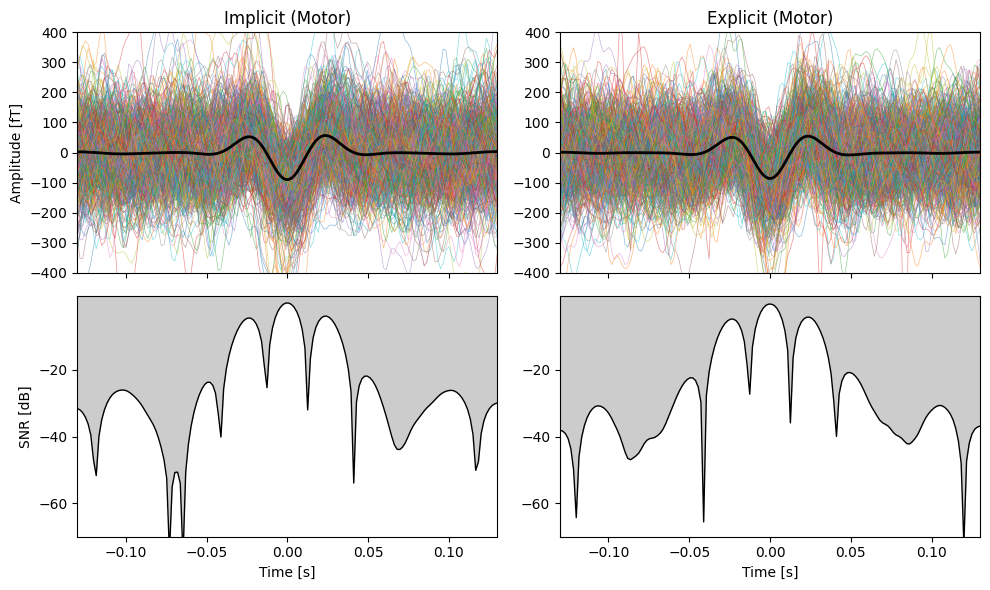

In [8]:
import matplotlib.pyplot as plt
import numpy as np

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(10, 6), sharex=True)

# --- LEFT COLUMN = IMPLICIT MOTOR ---
# 1) Waveforms
ax_top_left = axes[0, 0]
ax_top_left.plot(
    waveform_time,
    waveform_array_implicit_motor[::5000].T / 1e-15,  # downsample if needed
    lw=0.5, alpha=0.5
)
ax_top_left.plot(
    waveform_time,
    mean_waveform_implicit_motor / 1e-15,
    lw=2, color="black"
)
ax_top_left.set_ylim(-400, 400)
ax_top_left.set_xlim(-0.13, 0.13)
ax_top_left.set_ylabel("Amplitude [fT]")
ax_top_left.set_title("Implicit (Motor)")

# 2) SNR
ax_bot_left = axes[1, 0]
ax_bot_left.fill_between(
    waveform_time,
    np.zeros_like(waveform_time)+2,
    10 * np.log10(SNR_implicit_motor**2),
    lw=0, color="black", alpha=0.2
)
ax_bot_left.plot(
    waveform_time,
    10 * np.log10(SNR_implicit_motor**2),
    lw=1, color="black"
)
ax_bot_left.set_ylim(-70, 2)
ax_bot_left.set_xlim(-0.13, 0.13)
ax_bot_left.set_ylabel("SNR [dB]")
ax_bot_left.set_yticks([-20, -40, -60])
ax_bot_left.set_xlabel("Time [s]")

# --- RIGHT COLUMN = EXPLICIT MOTOR ---
# 1) Waveforms
ax_top_right = axes[0, 1]
ax_top_right.plot(
    waveform_time,
    waveform_array_explicit_motor[::5000].T / 1e-15,
    lw=0.5, alpha=0.5
)
ax_top_right.plot(
    waveform_time,
    mean_waveform_explicit_motor / 1e-15,
    lw=2, color="black"
)
ax_top_right.set_ylim(-400, 400)
ax_top_right.set_xlim(-0.13, 0.13)
ax_top_right.set_title("Explicit (Motor)")

# 2) SNR
ax_bot_right = axes[1, 1]
ax_bot_right.fill_between(
    waveform_time,
    np.zeros_like(waveform_time)+2,
    10 * np.log10(SNR_explicit_motor**2),
    lw=0, color="black", alpha=0.2
)
ax_bot_right.plot(
    waveform_time,
    10 * np.log10(SNR_explicit_motor**2),
    lw=1, color="black"
)
ax_bot_right.set_ylim(-70, 2)
ax_bot_right.set_xlim(-0.13, 0.13)
ax_bot_right.set_yticks([-20, -40, -60])
ax_bot_right.set_xlabel("Time [s]")

plt.tight_layout()
plt.show()


In [9]:
df_burst_behav_implicit = df_burst_behav[df_burst_behav["group"] == "Implicit"]
df_burst_behav_explicit = df_burst_behav[df_burst_behav["group"] == "Explicit"]

In [10]:

df_burst_behav_implicit["group"] = "Implicit"
df_burst_behav_explicit["group"] = "Explicit"

# Now filter each subset so that epoch == 'mot'
df_burst_behav_implicit_mot = df_burst_behav_implicit[
    df_burst_behav_implicit["epoch"] == "mot"
].copy()

df_burst_behav_explicit_mot = df_burst_behav_explicit[
    df_burst_behav_explicit["epoch"] == "mot"
].copy()

# Concatenate
df_lmm = pd.concat([df_burst_behav_implicit_mot, df_burst_behav_explicit_mot], 
                   ignore_index=True)

C:\Users\qmoreau\AppData\Local\Temp\ipykernel_26600\3174307440.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_burst_behav_implicit["group"] = "Implicit"
C:\Users\qmoreau\AppData\Local\Temp\ipykernel_26600\3174307440.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_burst_behav_explicit["group"] = "Explicit"


In [11]:
palette0 = sns.color_palette("magma_r", 3)
palette1 = sns.color_palette("mako_r", 3)

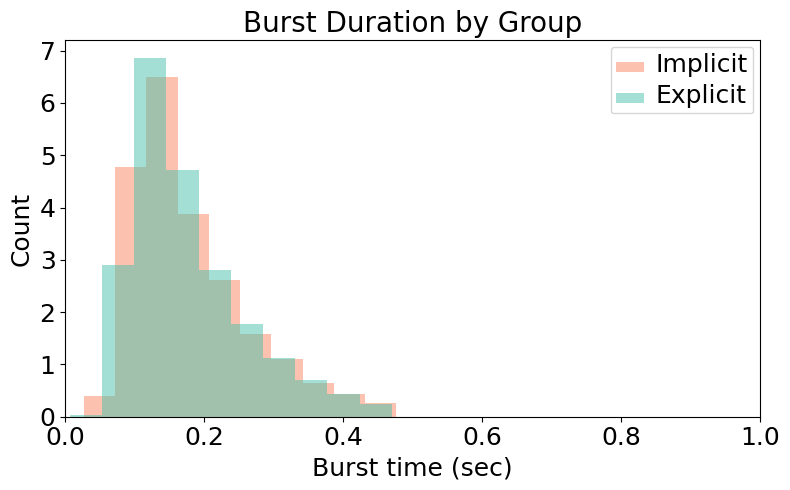

In [12]:
# Extract the burst duration data
fwhm_implicit = df_burst_behav_implicit.loc[
    df_burst_behav_implicit["epoch"] == "mot", 
    "fwhm_time"
].copy()

fwhm_explicit = df_burst_behav_explicit.loc[
    df_burst_behav_explicit["epoch"] == "mot", 
    "fwhm_time"
].copy()


# remove 4 sd outliers
fwhm_implicit_clean = fwhm_implicit[(np.abs(fwhm_implicit - fwhm_implicit.mean()) < 3 * fwhm_implicit.std())]
fwhm_explicit_clean = fwhm_explicit[(np.abs(fwhm_explicit - fwhm_explicit.mean()) < 3 * fwhm_explicit.std())]

# Create a figure with a single axis
fig, ax = plt.subplots(figsize=(8, 5))

# Plot both histograms on the same axis with slight transparency
ax.hist(
    fwhm_implicit_clean,
    bins=10,
    color=palette0[0],
    alpha=0.5,              # transparency
    linewidth=0.2,
    density=True,          
    label="Implicit"
)
ax.hist(
    fwhm_explicit_clean,
    bins=10,
    color=palette1[0],
    alpha=0.5,
    linewidth=0.2,
    density=True,
    label="Explicit"
)

ax.set_title("Burst Duration by Group", fontsize=20)
ax.set_xlabel("Burst time (sec)", fontsize=18)
ax.set_ylabel("Count", fontsize=18)
ax.set_xlim(0, 1)
ax.legend()

# all text is black and 18
plt.setp(ax.get_xticklabels(), fontsize=18, color="black")
plt.setp(ax.get_yticklabels(), fontsize=18, color="black")
plt.setp(ax.get_legend().get_texts(), fontsize=18, color="black")
plt.setp(ax.get_legend().get_title(), fontsize=18, color="black")



plt.tight_layout()
plt.show()

In [13]:

# Convert group to a categorical variable if desired
df_lmm["group"] = df_lmm["group"].astype("category")

# df_lmm = df_lmm[df_lmm["fwhm_time"] < (df_lmm["fwhm_time"].mean() + 3 * df_lmm["fwhm_time"].std())]


model = smf.mixedlm(
    formula="fwhm_time ~ group", 
    data=df_lmm, 
    groups=df_lmm["subject"]  # random intercept for subject
)

result = model.fit()
print(result.summary())

subject_means = (
    df_lmm
    .groupby(["subject", "group"], as_index=False)
    ["fwhm_time"]
    .mean()
)


subject_means.dropna(subset=["fwhm_time"], inplace=True)

# do a independent t-test to compare the means of the two groups
t, p = ttest_ind(
    subject_means.query("group == 'Implicit'")["fwhm_time"],
    subject_means.query("group == 'Explicit'")["fwhm_time"],
    equal_var=False
)

print(f"t = {t:.3f}, p = {p:.3f}")


c:\Users\qmoreau\anaconda3\Lib\site-packages\statsmodels\regression\mixed_linear_model.py:2238: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
c:\Users\qmoreau\anaconda3\Lib\site-packages\statsmodels\regression\mixed_linear_model.py:2262: ConvergenceWarning: The Hessian matrix at the estimated parameter values is not positive definite.
  warnings.warn(msg, ConvergenceWarning)


           Mixed Linear Model Regression Results
Model:            MixedLM  Dependent Variable: fwhm_time   
No. Observations: 6506380  Method:             REML        
No. Groups:       37       Scale:              0.0093      
Min. group size:  116784   Log-Likelihood:     5995476.4031
Max. group size:  207473   Converged:          Yes         
Mean group size:  175848.1                                 
-----------------------------------------------------------
                   Coef. Std.Err.   z   P>|z| [0.025 0.975]
-----------------------------------------------------------
Intercept          0.183    0.023 8.055 0.000  0.138  0.227
group[T.Implicit]  0.004    0.032 0.128 0.899 -0.058  0.066
Group Var          0.009                                   

t = 1.050, p = 0.302


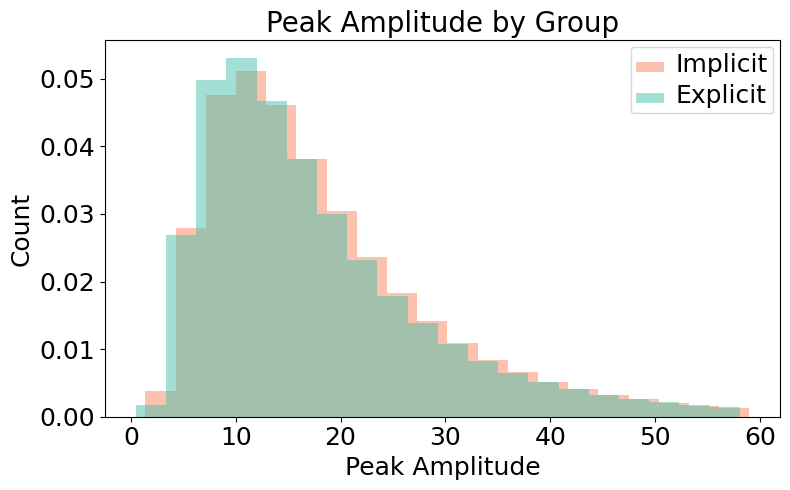

In [14]:

peak_amp_base_implicit = df_burst_behav_implicit.loc[
    df_burst_behav_implicit["epoch"] == "mot", 
    "peak_amp_base"
].copy()

peak_amp_base_explicit = df_burst_behav_explicit.loc[
    df_burst_behav_explicit["epoch"] == "mot", 
    "peak_amp_base"
].copy()

# drop 3 sd outliers
peak_amp_base_implicit = peak_amp_base_implicit[peak_amp_base_implicit < peak_amp_base_implicit.mean() + 3*peak_amp_base_implicit.std()] * 1e15
peak_amp_base_explicit = peak_amp_base_explicit[peak_amp_base_explicit < peak_amp_base_explicit.mean() + 3*peak_amp_base_explicit.std()] * 1e15

# linspace to have same bins
33
# Create a figure with a single axis
fig, ax = plt.subplots(figsize=(8, 5))

# Plot both histograms on the same axis with slight transparency
ax.hist(
    peak_amp_base_implicit, bins=20, alpha=0.5, density=True, label="Implicit", color=palette0[0],
)
ax.hist(
    peak_amp_base_explicit, bins=20, alpha=0.5, density=True, label="Explicit", color=palette1[0],
)
ax.set_title("Peak Amplitude by Group", fontsize=20)
ax.set_xlabel("Peak Amplitude", fontsize=18)
ax.set_ylabel("Count", fontsize=18)
# ax.set_xlim(0, 0.25e-12)
ax.legend()

# all text is black and 18
plt.setp(ax.get_xticklabels(), fontsize=18, color="black")
plt.setp(ax.get_yticklabels(), fontsize=18, color="black")
plt.setp(ax.get_legend().get_texts(), fontsize=18, color="black")
plt.setp(ax.get_legend().get_title(), fontsize=18, color="black")


plt.tight_layout()
plt.show()

In [15]:

model = smf.mixedlm(
    formula="peak_amp_base ~ group", 
    data=df_lmm, 
    groups=df_lmm["subject"]  # random intercept for subject
)

result = model.fit()
print(result.summary())

subject_means = (
    df_lmm
    .groupby(["subject", "group"], as_index=False)
    ["peak_amp_base"]
    .mean()
)

subject_means.dropna(subset=["peak_amp_base"], inplace=True)

# do a independent t-test to compare the means of the two groups
t, p = ttest_ind(
    subject_means.query("group == 'Implicit'")["peak_amp_base"],
    subject_means.query("group == 'Explicit'")["peak_amp_base"],
    equal_var=False
)

print(f"t = {t:.3f}, p = {p:.3f}")

c:\Users\qmoreau\anaconda3\Lib\site-packages\statsmodels\regression\mixed_linear_model.py:2238: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
c:\Users\qmoreau\anaconda3\Lib\site-packages\statsmodels\regression\mixed_linear_model.py:2262: ConvergenceWarning: The Hessian matrix at the estimated parameter values is not positive definite.
  warnings.warn(msg, ConvergenceWarning)


            Mixed Linear Model Regression Results
Model:            MixedLM  Dependent Variable: peak_amp_base 
No. Observations: 6506380  Method:             REML          
No. Groups:       37       Scale:              0.0000        
Min. group size:  116784   Log-Likelihood:     199270396.3373
Max. group size:  207473   Converged:          Yes           
Mean group size:  175848.1                                   
-------------------------------------------------------------
                     Coef. Std.Err.   z   P>|z| [0.025 0.975]
-------------------------------------------------------------
Intercept            0.000    0.000 6.515 0.000  0.000  0.000
group[T.Implicit]    0.000    0.000 0.235 0.814 -0.000  0.000
Group Var            0.000                                   

t = 0.508, p = 0.615


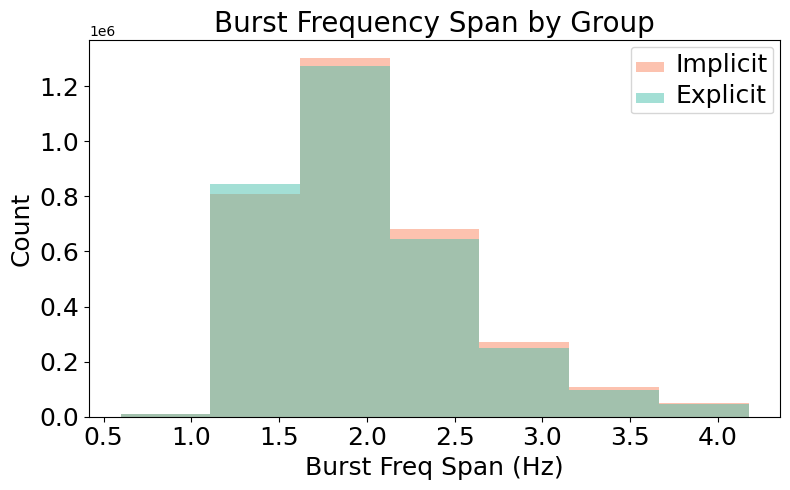

In [16]:

# Extract the burst duration data

fwhm_freq_implicit = df_burst_behav_implicit.loc[
    df_burst_behav_implicit["epoch"] == "mot", 
    "fwhm_freq"
].copy()

fwhm_freq_explicit = df_burst_behav_explicit.loc[
    df_burst_behav_explicit["epoch"] == "mot", 
    "fwhm_freq"
].copy()

# remove 4 sd outliers
fwhm_freq_implicit = fwhm_freq_implicit[(np.abs(fwhm_freq_implicit - fwhm_freq_implicit.mean()) < 3 * fwhm_freq_implicit.std())]
fwhm_freq_explicit = fwhm_freq_explicit[(np.abs(fwhm_freq_explicit - fwhm_freq_explicit.mean()) < 3 * fwhm_freq_explicit.std())]

# Create a figure with a single axis
fig, ax = plt.subplots(figsize=(8, 5))

# Plot both histograms on the same axis with slight transparency
ax.hist(
    fwhm_freq_implicit,
    bins=7,
    color=palette0[0],
    alpha=0.5,              # transparency
    linewidth=0.2,
    # density=True,          
    label="Implicit"
)
ax.hist(
    fwhm_freq_explicit,
    bins=7,
    color=palette1[0],
    alpha=0.5,
    linewidth=0.2,
    # density=True,
    label="Explicit"
)

ax.set_title("Burst Frequency Span by Group", fontsize=20)
ax.set_xlabel("Burst Freq Span (Hz)", fontsize=18)
ax.set_ylabel("Count", fontsize=18)
# ax.set_xlim(0, 1)
ax.legend()

# all text is black and 18
plt.setp(ax.get_xticklabels(), fontsize=18, color="black")
plt.setp(ax.get_yticklabels(), fontsize=18, color="black")
plt.setp(ax.get_legend().get_texts(), fontsize=18, color="black")
plt.setp(ax.get_legend().get_title(), fontsize=18, color="black")

plt.tight_layout()
plt.show()

In [17]:
model = smf.mixedlm(
    formula="fwhm_freq ~ group", 
    data=df_lmm, 
    groups=df_lmm["subject"]  # random intercept for subject
)

result = model.fit()
print(result.summary())


subject_means = (
    df_lmm
    .groupby(["subject", "group"], as_index=False)
    ["fwhm_freq"]
    .mean()
)

subject_means.dropna(subset=["fwhm_freq"], inplace=True)

# do a independent t-test to compare the means of the two groups
t, p = ttest_ind(
    subject_means.query("group == 'Implicit'")["fwhm_freq"],
    subject_means.query("group == 'Explicit'")["fwhm_freq"],
    equal_var=False
)

print(f"t = {t:.3f}, p = {p:.3f}")

c:\Users\qmoreau\anaconda3\Lib\site-packages\statsmodels\regression\mixed_linear_model.py:2262: ConvergenceWarning: The Hessian matrix at the estimated parameter values is not positive definite.
  warnings.warn(msg, ConvergenceWarning)


           Mixed Linear Model Regression Results
Model:            MixedLM  Dependent Variable: fwhm_freq    
No. Observations: 6506380  Method:             REML         
No. Groups:       37       Scale:              0.6640       
Min. group size:  116784   Log-Likelihood:     -7900295.0536
Max. group size:  207473   Converged:          Yes          
Mean group size:  175848.1                                  
------------------------------------------------------------
                   Coef. Std.Err.   z    P>|z| [0.025 0.975]
------------------------------------------------------------
Intercept          1.994    0.192 10.384 0.000  1.618  2.371
group[T.Implicit]  0.034    0.268  0.126 0.900 -0.492  0.559
Group Var          0.664                                    

t = 1.209, p = 0.236


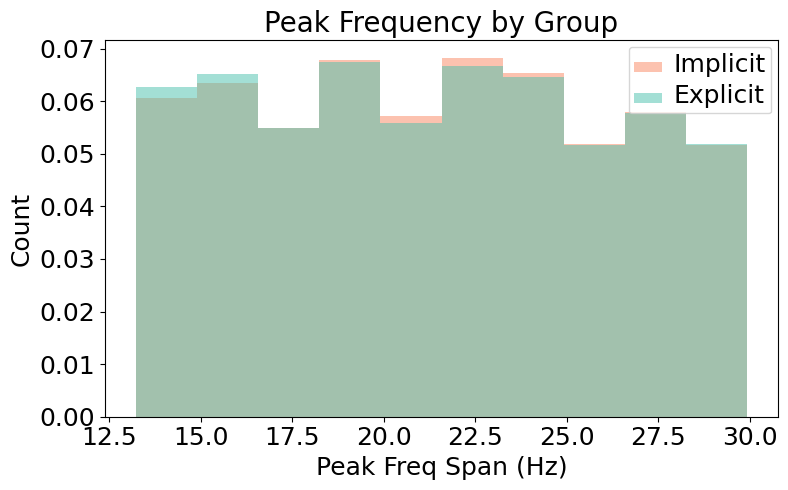

In [18]:

# Extract the burst duration data
peak_freq_implicit = df_burst_behav_implicit["peak_freq"]
peak_freq_explicit = df_burst_behav_explicit["peak_freq"]

# remove 4 sd outliers
peak_freq_implicit = peak_freq_implicit[(np.abs(peak_freq_implicit - peak_freq_implicit.mean()) < 73 * peak_freq_implicit.std())]
peak_freq_explicit = peak_freq_explicit[(np.abs(peak_freq_explicit - peak_freq_explicit.mean()) < 3 * peak_freq_explicit.std())]

# Create a figure with a single axis
fig, ax = plt.subplots(figsize=(8, 5))

# Plot both histograms on the same axis with slight transparency
ax.hist(
    peak_freq_implicit,
    bins=10,
    color=palette0[0],
    alpha=0.5,              # transparency
    linewidth=0.2,
    density=True,          
    label="Implicit"
)
ax.hist(
    peak_freq_explicit,
    bins=10,
    color=palette1[0],
    alpha=0.5,
    linewidth=0.2,
    density=True,
    label="Explicit"
)

ax.set_title("Peak Frequency by Group", fontsize=20)
ax.set_xlabel("Peak Freq Span (Hz)", fontsize=18)
ax.set_ylabel("Count", fontsize=18)
# ax.set_xlim(0, 1)
ax.legend()


# all text is black and 18
plt.setp(ax.get_xticklabels(), fontsize=18, color="black")
plt.setp(ax.get_yticklabels(), fontsize=18, color="black")
plt.setp(ax.get_legend().get_texts(), fontsize=18, color="black")
plt.setp(ax.get_legend().get_title(), fontsize=18, color="black")

plt.tight_layout()
plt.show()

In [19]:
model = smf.mixedlm(
    formula="peak_freq ~ group", 
    data=df_lmm, 
    groups=df_lmm["subject"]  # random intercept for subject
)

result = model.fit()
print(result.summary())


subject_means = (
    df_lmm
    .groupby(["subject", "group"], as_index=False)
    ["peak_freq"]
    .mean()
)

subject_means.dropna(subset=["peak_freq"], inplace=True)

# do a independent t-test to compare the means of the two groups
t, p = ttest_ind(
    subject_means.query("group == 'Implicit'")["peak_freq"],
    subject_means.query("group == 'Explicit'")["peak_freq"],
    equal_var=False
)

print(f"t = {t:.3f}, p = {p:.3f}")

c:\Users\qmoreau\anaconda3\Lib\site-packages\statsmodels\regression\mixed_linear_model.py:2262: ConvergenceWarning: The Hessian matrix at the estimated parameter values is not positive definite.
  warnings.warn(msg, ConvergenceWarning)


            Mixed Linear Model Regression Results
Model:            MixedLM  Dependent Variable: peak_freq     
No. Observations: 6506380  Method:             REML          
No. Groups:       37       Scale:              22.5895       
Min. group size:  116784   Log-Likelihood:     -19374138.5593
Max. group size:  207473   Converged:          Yes           
Mean group size:  175848.1                                   
-------------------------------------------------------------
                   Coef.  Std.Err.   z    P>|z| [0.025 0.975]
-------------------------------------------------------------
Intercept          21.327    1.120 19.038 0.000 19.131 23.523
group[T.Implicit]  -0.030    1.563 -0.019 0.985 -3.094  3.034
Group Var          22.589                                    

t = -0.279, p = 0.782
